In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Khai báo các thư viện 
import os
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np

import time

import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras
from tensorflow.keras import layers, models

from keras.callbacks import ModelCheckpoint #lưu lại huán luyến tốt nhất
from tensorflow.keras.callbacks import Callback


In [ ]:
# Create input folder:
!unzip /content/drive/MyDrive/nghien_cuu_khoa_hoc/dataset/original_imgs/padded_img.zip

# Create output folder
!unzip /content/drive/MyDrive/nghien_cuu_khoa_hoc/dataset/labels/text_label.zip

Streaming output truncated to the last 5000 lines.
 extracting: word_output/20160518_0151_25432_1_tg_4_5_12.txt  
 extracting: word_output/20151208_0146_7105_2_tg_1_3_9.txt  
 extracting: word_output/20160513_0133_9244_1_tg_3_6_5.txt  
 extracting: word_output/20160603_0185_25300_tg_0_3_5.txt  
 extracting: word_output/20160513_0134_9244_2_tg_2_2_19.txt  
 extracting: word_output/20160113_0068_25300_tg_1_4_0.txt  
 extracting: word_output/20160412_0090_9415_1_tg_3_3_20.txt  
 extracting: word_output/20160122_0077_25849_1_tg_2_0_14.txt  
 extracting: word_output/20160428_0109_25627_3_tg_2_3_3.txt  
 extracting: word_output/20140927_0033_5932_1_tg_3_4_11.txt  
 extracting: word_output/20160602_0182_25432_1_tg_1_2_14.txt  
 extracting: word_output/20160113_0070_28472_1_tg_3_3_5.txt  
 extracting: word_output/20160428_0108_25627_1_tg_3_5_4.txt  
 extracting: word_output/20160506_0115_26558_1_tg_4_3_4.txt  
 extracting: word_output/20150216_0009_9129_3_tg_3_1_21.txt  
 extracting: word_outp

In [ ]:
# Đếm số lượng file trong mỗi folder

!ls /content/word_output/ | wc -l
!ls /content/content/padded_img/ | wc -l

110746
110746


In [ ]:
VIET_CHAR = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'ă',
       'â', 'b', 'c', 'd', 'đ', 'e', 'ê', 'g', 'h', 'i', 'k', 'l', 'm',
       'n', 'o', 'ô', 'ơ', 'p', 'q', 'r', 's', 't', 'u', 'ư', 'v', 'x',
       'y', 'à', 'á', 'ã', 'ạ', 'ả', 'ằ', 'ắ', 'ẵ', 'ặ', 'ẳ', 'ầ', 'ấ',
       'ẫ', 'ậ', 'ẩ', 'è', 'é', 'ẽ', 'ẹ', 'ẻ', 'ề', 'ế', 'ễ', 'ệ', 'ể',
       'ì', 'í', 'ĩ', 'ị', 'ỉ', 'ò', 'ó', 'õ', 'ọ', 'ỏ', 'ồ', 'ố', 'ỗ',
       'ộ', 'ổ', 'ờ', 'ớ', 'ỡ', 'ợ', 'ở', 'ù', 'ú', 'ũ', 'ụ', 'ủ', 'ừ',
       'ứ', 'ữ', 'ự', 'ử', 'ỳ', 'ý', 'ỹ', 'ỵ', 'ỷ', 'f', 'j', 'w', 'A',
       'Ă', 'Â', 'B', 'C', 'D', 'Đ', 'E', 'Ê', 'G', 'H', 'I', 'K', 'L',
       'M', 'N', 'O', 'Ô', 'Ơ', 'P', 'Q', 'R', 'S', 'T', 'U', 'Ư', 'V',
       'X', 'Y', 'À', 'Á', 'Ã', 'Ạ', 'Ả', 'Ằ', 'Ắ', 'Ẵ', 'Ặ', 'Ẳ', 'Ầ',
       'Ấ', 'Ẫ', 'Ậ', 'Ẩ', 'È', 'É', 'Ẽ', 'Ẹ', 'Ẻ', 'Ề', 'Ế', 'Ễ', 'Ệ',
       'Ể', 'Ì', 'Í', 'Ĩ', 'Ị', 'Ỉ', 'Ò', 'Ó', 'Õ', 'Ọ', 'Ỏ', 'Ồ', 'Ố',
       'Ỗ', 'Ộ', 'Ổ', 'Ờ', 'Ớ', 'Ỡ', 'Ợ', 'Ở', 'Ù', 'Ú', 'Ũ', 'Ụ', 'Ủ',
       'Ừ', 'Ứ', 'Ữ', 'Ự', 'Ử', 'Ỳ', 'Ý', 'Ỹ', 'Ỵ', 'Ỷ', 'F', 'J', 'W',
       '@']

len(VIET_CHAR)

195

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

# Sử dụng StringLookup để tạo ra hai hàm:
# 1. char_to_num() -> Chuyển các từ về số   vd: anh -> [11, 26, 21] - (index + 1) của các ký tự này trong bảng VIET_CHAR (+1 là bởi vì)
# StringLookup sẽ tự động chèn thêm một ký tự nữa ở index 0 (ký tự đó là [UNK]) 

# 2. num_to_char() -> Để chuyển đổi ngược lại

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=VIET_CHAR, mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

In [ ]:
# Hai đường dẫn chứa folder input và output sau khi giải nén lưu vào 2 biến

INPUT_DIR = r'/content/content/padded_img/'
OUTPUT_DIR = r'/content/word_output/'

In [ ]:
dataset = []

# Tạo ra list dataset, list này sẽ lưu các phần tử, với mỗi phần tử là một tuple, chứa hai thành phần: 
# đường dẫn của ảnh và đường dẫn text tương ứng với ảnh đó

for image_file in os.listdir(INPUT_DIR):
    label_file = f'{OUTPUT_DIR}{image_file[:-4]}.txt'

    x_i = f'{INPUT_DIR}{image_file}'
    y_i = f'{label_file}'

    if os.path.isfile(x_i) and os.path.isfile(y_i):
        dataset.append((x_i, y_i))

# Chọn seed = 1 để trộn ngẫu nhiên các phần tử trong list dataset
# random.seed(1)
random.shuffle(dataset)

# Xem qua 10 phần tử của dataset, cấu trúc mỗi phần tử được giải thích bên trên
dataset[:10]

[('/content/content/padded_img/20151114_0054_25472_tg_4_4_11.png',
  '/content/word_output/20151114_0054_25472_tg_4_4_11.txt'),
 ('/content/content/padded_img/20160412_0087_9244_3_tg_1_2_20.png',
  '/content/word_output/20160412_0087_9244_3_tg_1_2_20.txt'),
 ('/content/content/padded_img/20160125_0080_25627_1_tg_4_4_0.png',
  '/content/word_output/20160125_0080_25627_1_tg_4_4_0.txt'),
 ('/content/content/padded_img/20160524_0166_9415_2_tg_0_4_1.png',
  '/content/word_output/20160524_0166_9415_2_tg_0_4_1.txt'),
 ('/content/content/padded_img/20140921_0002_5498_2_tg_5_1_15.png',
  '/content/word_output/20140921_0002_5498_2_tg_5_1_15.txt'),
 ('/content/content/padded_img/20140603_0026_BCCTC_tg_2_0_5.png',
  '/content/word_output/20140603_0026_BCCTC_tg_2_0_5.txt'),
 ('/content/content/padded_img/20151214_0065_26558_2_tg_1_3_10.png',
  '/content/word_output/20151214_0065_26558_2_tg_1_3_10.txt'),
 ('/content/content/padded_img/20150323_0019_25432_1_tg_4_2_3.png',
  '/content/word_output/2015

In [ ]:
# Ta chia ra các bộ: train - dev - test trong dataset, do đã trộn dữ liệu nên có thể chọn chỉ số
i_train = 66991
i_val = 85631

dataset_train = dataset[:i_train]
dataset_val = dataset[i_train:i_val]
dataset_test = dataset[i_val:]

len(dataset_train), len(dataset_val), len(dataset_test)

(66991, 18640, 25115)

In [ ]:
# Với dataset_train, dataset_val, dataset_test, tách ra thành hai thành phần con ảnh (imgs) và nhãn (labels)
# các thành phần này vẫn đang chứa đường dẫn

imgs_path_train = [tup[0] for tup in dataset_train]
labels_path_train = [tup[1] for tup in dataset_train]

imgs_path_val = [tup[0] for tup in dataset_val]
labels_path_val = [tup[1] for tup in dataset_val]

imgs_path_test = [tup[0] for tup in dataset_test]
labels_path_test = [tup[1] for tup in dataset_test]

print(len(imgs_path_train), len(labels_path_train))
print(len(imgs_path_val), len(labels_path_val))
print(len(imgs_path_test), len(labels_path_test))

i_test = (8, 10)

print('train:')
print(imgs_path_train[i_test[0]:i_test[1]])
print(labels_path_train[i_test[0]:i_test[1]])

print('val:')
print(imgs_path_val[i_test[0]:i_test[1]])
print(labels_path_val[i_test[0]:i_test[1]])

print('test:')
print(imgs_path_test[i_test[0]:i_test[1]])
print(labels_path_test[i_test[0]:i_test[1]])

66991 66991
18640 18640
25115 25115
train:
['/content/content/padded_img/20160525_0168_25283_1_tg_0_3_3.png', '/content/content/padded_img/20140920_0012_49_2_tg_2_3_1.png']
['/content/word_output/20160525_0168_25283_1_tg_0_3_3.txt', '/content/word_output/20140920_0012_49_2_tg_2_3_1.txt']
val:
['/content/content/padded_img/20140603_0040_BCCTC_tg_1_0_0.png', '/content/content/padded_img/20140603_0026_KQBDVN_tg_2_3_11.png']
['/content/word_output/20140603_0040_BCCTC_tg_1_0_0.txt', '/content/word_output/20140603_0026_KQBDVN_tg_2_3_11.txt']
test:
['/content/content/padded_img/20160514_0137_25272_tg_1_6_2.png', '/content/content/padded_img/20160428_0108_25627_1_tg_0_3_0.png']
['/content/word_output/20160514_0137_25272_tg_1_6_2.txt', '/content/word_output/20160428_0108_25627_1_tg_0_3_0.txt']


In [ ]:
# image = cv2.imread(imgs_path_test[0], cv2.COLOR_BGR2GRAY)
# image = cv2.imread(imgs_path_test[0], cv2.COLOR_BGR2RGB)
# cv2.imshow(image)
# plt.imshow(image)

In [ ]:
# Với các thành phần labels (labels_path_(train/val/test)), tiếp theo đây sẽ đọc file và lấy ra text tương ứng


y_train = []
y_val = []
y_test = []

def filepath_2_text(labels_path, y):
    for label_path in labels_path:
        with open(label_path, 'rt', encoding='utf-8') as f:
            y.append(f.read().strip())

filepath_2_text(labels_path_train, y_train)
filepath_2_text(labels_path_val, y_val)
filepath_2_text(labels_path_test, y_test)

# print('len:')
# print(len(y_train))
# print(len(y_val))
# print(len(y_test))

# print('show texts:')
# print(y_train[:10])
# print(y_val[:10])
# print(y_test[:10])


y = y_train + y_val + y_test

# # Lấy ra độ dài của ký tự dài nhất (Để sau này ta padding các từ còn lại bằng cách thêm một giả ký tự (sau khi đã chuyển sang dạng số ở bước sau))
# # max_len = max(len(text) for text in y)
max_text = max(y, key=len)
max_len = len(max_text)
print(f'longest word is {max_text}')
print(f'maximum length of a word is {max_len}')

longest word is Environment
maximum length of a word is 11


In [ ]:
# widths = []
# heights = []
# def filepath_2_text(imgs_path):
#     for image_path in imgs_path:
#         img = cv2.imread(image_path)
#         (height, width, _) = img.shape
#         heights.append(height)
#         widths.append(width)

# filepath_2_text(imgs_path_train)
# filepath_2_text(imgs_path_val)
# filepath_2_text(imgs_path_test)

In [ ]:
# min_height = min(heights)
# max_height = max(heights)
# min_width = min(widths)
# max_width = max(widths)

In [ ]:
# (min_height, max_height, min_width, max_width)

cấp


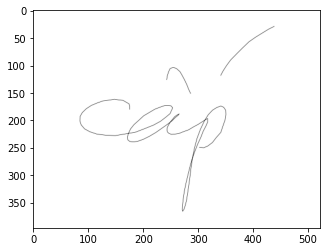

In [ ]:
i = 69
with open(labels_path_train[i], 'rt', encoding='utf-8') as f:
    print(f.read())

img_path = imgs_path_train[i]
img = cv2.imread(img_path)
plt.imshow(img)

In [ ]:
# image.shape

In [ ]:
batch_size = 64
padding_token = 299
image_width = 128
image_height = 96
channels = 1

def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
        constant_values=255
    )
    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

def preprocess_image(image_path):
    image = tf.io.read_file(image_path) # doc anh tu duong dan anh
    image = tf.image.decode_png(image, channels=channels) # chuyen cac anh vua doc thanh dang ma tran voi so channels anh = channels
    image = distortion_free_resize(image, (image_width, image_height)) # resize + padding lai anh
    image = tf.cast(image, tf.float32) / 255.0
    return image

def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label

def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}

def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE) # chia dataset thanh cac minibatch voi kich thuoc batch_size

In [ ]:
# a = tf.io.read_file('dataset/imgs64/imgs64/20140603_0040_BCCTC_tg_0_5_9.png')
# tf.image.decode_png(a, 3)

In [ ]:
train_ds = prepare_dataset(imgs_path_train, y_train)
validation_ds = prepare_dataset(imgs_path_val, y_val)
test_ds = prepare_dataset(imgs_path_test, y_test)

In [ ]:
# Dọn dẹp

del dataset
del dataset_test
del dataset_val
del dataset_train
del imgs_path_train
del imgs_path_test
del imgs_path_val
del labels_path_test
del labels_path_val
del labels_path_train
del y_train
del y_val

In [ ]:
list(train_ds.take(1))[0]['image'].shape

TensorShape([64, 128, 96, 1])

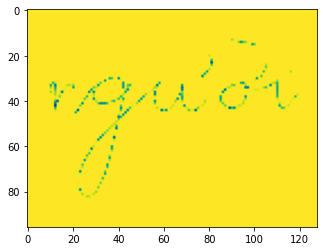

In [ ]:
img = list(train_ds.take(1))[0]['image'][60]
img = tf.image.flip_left_right(img)
img = tf.transpose(img, perm=[1, 0, 2])
plt.imshow(img)

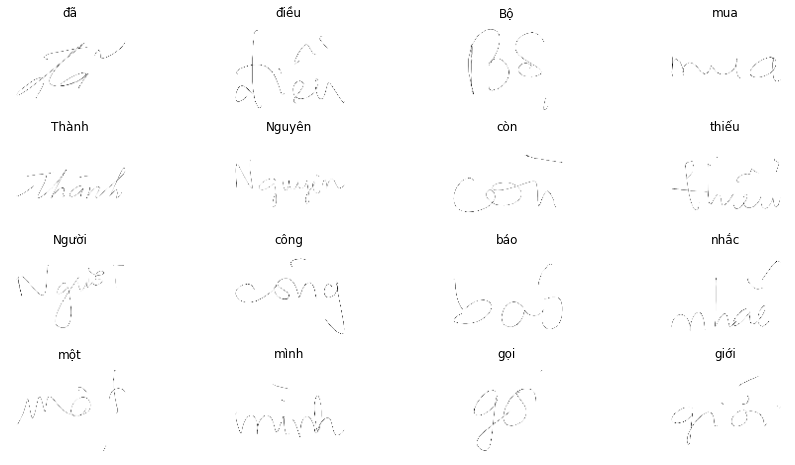

In [ ]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()

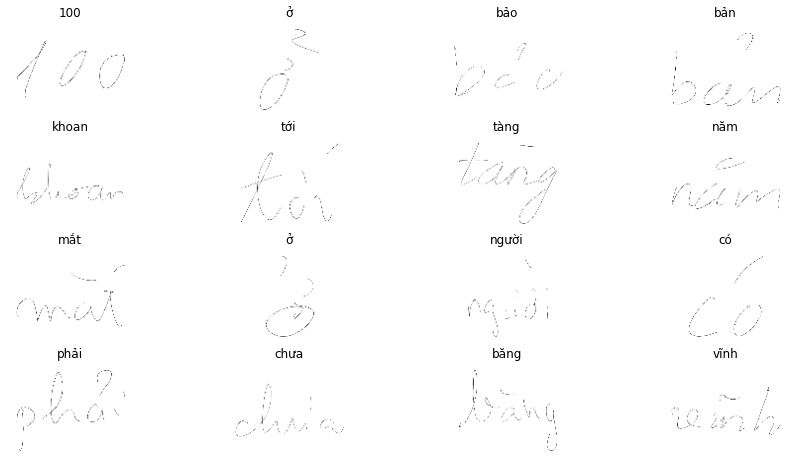

In [ ]:
for data in validation_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()

-----

# **Model**

In [ ]:
class CTCLayer(tf.keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred

In [ ]:
# Assuming train_ds is a tf.data.Dataset object
image_iterator = iter(train_ds.take(1))
batch = next(image_iterator)

# Get the first image in the batch
image = batch["image"][0]

# Convert the image tensor to a NumPy array
image_array = image.numpy()


height = image_array.shape[1]
width = image_array.shape[0]
channels = image_array.shape[2]

height, width, channels


(96, 128, 1)

In [ ]:
def cnn_blocks(layer, filters_num, pool_size, stride, kernel_ini, padding, name_index, BN = False, pooling = False):
    layer = layers.Conv2D(
        filters=filters_num, 
        kernel_size = (3, 3),
        kernel_initializer = kernel_ini,
        padding = padding, 
        name=f'Conv{name_index}'
    )(layer)

    if BN:
        layer = layers.BatchNormalization(name=f'batch{name_index}')(layer)

    if pooling:
        layer = layers.MaxPooling2D(pool_size=pool_size, strides=stride, name=f'maxpool{name_index}')(layer)

    layer = layers.Activation('relu', name=f'relu{name_index}')(layer)
    # layer = layers.BatchNormalization(name=f'batch{name_index}')(layer)
    # layer = layers.Dropout(rate=dropout_rate)(layer)

    return layer

def build_model():

    input_img = tf.keras.Input(shape=(width, height, channels), name="image")
    labels = tf.keras.layers.Input(name="label", shape=(None,))

    layer = cnn_blocks(input_img, 64, (2, 2), 2,"he_normal", "same", 1, pooling = True)
    layer = cnn_blocks(layer, 64, (2, 2), 2,"he_normal", "same", 2)
    layer = cnn_blocks(layer, 128, (2, 2), 2,"he_normal", "same", 3, BN = True, pooling = True)
    layer = cnn_blocks(layer, 128, (2, 2), 2,"he_normal", "same", 4, BN = True)
    # layer = cnn_blocks(layer, 256, (2, 2), 1,"he_normal", "same", 5, BN = True)
    # layer = cnn_blocks(layer, 128, (2, 2), 1,"he_normal", "same", 6, BN = True)
    layer = cnn_blocks(layer, 256, (2, 2), 2,"he_normal", "same", 7, BN = True, pooling = True)
    # layer = cnn_blocks(layer, 512, (2, 2), 2,"he_normal", "same", 8)

    # layer =keras.layers.MaxPooling2D(pool_size=(1, 2), name='pooling_end')



    # print(layer)
    timesteps = width // 8
    
    # print((timesteps ,width))


    layer = layers.Reshape(target_shape=(timesteps, -1), name='reshape')(layer)

    # print(layer)

    # layer = layers.Dense(256, activation='relu', name='dense1')(layer)
    # layer = layers.Dropout(0.5)(layer)

    layer = layers.Bidirectional(layers.LSTM(128, dropout = 0.2, return_sequences=True, activation='tanh', name='blstm1'))(layer)
    layer = layers.Bidirectional(layers.LSTM(128, dropout = 0.2, return_sequences=True, activation='tanh', name='blstm2'))(layer)

    layer = layers.Dense(len(char_to_num.get_vocabulary()) + 2, activation="softmax", name='last_dense')(layer)
    output = CTCLayer(name="ctc_loss")(labels, layer)

    model = tf.keras.models.Model(
        inputs=[input_img, labels], outputs=output
    )


    return model

In [ ]:
model = build_model()
model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 96, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 96, 64)  640         ['image[0][0]']                  
                                                                                                  
 maxpool1 (MaxPooling2D)        (None, 64, 48, 64)   0           ['Conv1[0][0]']                  
                                                                                                  
 relu1 (Activation)             (None, 64, 48, 64)   0           ['maxpool1[0][0]']           

------

# BEST WEIGHT

In [ ]:
PATH_MODEL = r'/content/drive/MyDrive/nghien_cuu_khoa_hoc/draft/hugdo/save_model/best_weight_originalV3.hdf5'

In [ ]:
class CTCLayer(tf.keras.layers.Layer):
    def __init__(self, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred


In [ ]:
with keras.utils.custom_object_scope({'CTCLayer': CTCLayer}):
    loaded_model = tf.keras.models.load_model(PATH_MODEL)


In [ ]:
def lev(s, r):
    if len(s) == 0:
        return len(r)

    if len(r) == 0:
        return len(s)

    if s[0] == r[0]:
        return lev(s[1:], r[1:])
    
    return 1 + min(lev(s[1:], r), lev(s, r[1:]), lev(s[1:], r[1:]))

def CER(truth, pred):
    return (100 / len(truth)) * lev(truth, pred)


def CER_of(data):
    batch_pred = []
    batch_truth = []
    num_batches = tf.data.experimental.cardinality(data).numpy()
    for mini_batch in data.take(num_batches):
        batch_images = mini_batch["image"]
        batch_texts = mini_batch['label']

        # Make sure to provide two inputs to the model's predict function
        preds = loaded_model.predict([batch_images, batch_texts])
        pred_texts = decode_batch_predictions(preds)
        truth_texts = decode_batch_predictions(batch_texts, truth=False)

        batch_pred += pred_texts
        batch_truth += truth_texts

    batch_pred = np.array(batch_pred)
    batch_truth = np.array(batch_truth)

    len_data = len(batch_pred)

    valid_distances = 0
    for i in range(len_data):
        valid_distances += CER(batch_truth[i], batch_pred[i])

    average_distance = valid_distances / len_data

    return average_distance




CER_train = CER_of(train_ds)
CER_val = CER_of(validation_ds)
CER_test = CER_of(test_ds)


print(f"CER of training data: {CER_train}")
print(f"CER of validation data: {CER_val}")
print(f"CER of test data: {CER_test}")



1/1 [==============================] - 1s 526ms/step
CER of training data: 2.9428976837211085
CER of validation data: 3.097183902173186
CER of test data: 2.8525180992829853


______

In [ ]:
from tensorflow.keras.callbacks import CSVLogger, TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback

In [ ]:
# def lev(s, r):
#     if len(s) == 0:
#         return len(r)

#     if len(r) == 0:
#         return len(s)

#     # if s[0] == r[0]:
#         return lev(s[1:], r[1:])
    
#     return 1 + min(lev(s[1:], r), lev(s, r[1:]), lev(s[1:], r[1:]))

# def CER(truth, pred):
#     return (100 / len(truth)) * lev(truth, pred)


In [ ]:
# class CERCallback(keras.callbacks.Callback):
#     def __init__(self, train_data, val_data):
#         super().__init__()
#         self.train_data = train_data
#         self.val_data = val_data

#     def on_epoch_end(self, epoch, logs=None):
#         if logs is None:
#             logs = {}
#         train_cer = self.compute_cer(self.train_data)
#         val_cer = self.compute_cer(self.val_data)
#         logs["train_cer"] = train_cer
#         logs["val_cer"] = val_cer
#         print(f"\ntrain_cer: {train_cer:.4f}, val_cer: {val_cer:.4f}\n")

#     def compute_cer(self, data):
#         batch_pred = []
#         batch_truth = []
#         num_batches = tf.data.experimental.cardinality(data).numpy()
#         for mini_batch in data.take(num_batches):
#             batch_images = mini_batch["image"]
#             batch_texts = mini_batch["label"]
#             preds = self.model.predict(batch_images)
#             pred_texts = decode_batch_predictions(preds)
#             truth_texts = decode_batch_predictions(batch_texts, truth=False)
#             batch_pred += pred_texts
#             batch_truth += truth_texts
#         batch_pred = np.array(batch_pred)
#         batch_truth = np.array(batch_truth)
#         len_data = len(batch_pred)
#         valid_distances = 0
#         for i in range(len_data):
#             valid_distances += CER(batch_truth[i], batch_pred[i])
#         average_distance = valid_distances / len_data
#         return average_distance


In [ ]:
# class CERCallback(tf.keras.callbacks.Callback):
#     """
#     Callback để tính toán và lưu giá trị CER sau mỗi epoch.
#     """
#     def __init__(self, validation_data):
#         super().__init__()
#         self.validation_data = validation_data
#         self.cer_history = []

#     def on_epoch_end(self, epoch, logs=None):
#         # Tính toán CER trên tập validation.
#         cer = self.calculate_cer()
#         print(f"\nValidation CER: {cer:.4f}")
        
#         # Lưu giá trị CER vào danh sách.
#         self.cer_history.append(cer)

#     def calculate_cer(self):
#         """
#         Tính toán CER trên tập validation.

#         Returns:
#             float: Giá trị CER.
#         """
#         batch_pred = []
#         batch_truth = []
#         num_batches = tf.data.experimental.cardinality(data).numpy()
#         for mini_batch in data.take(num_batches):
#             batch_images = mini_batch["image"]
#             batch_texts = mini_batch["label"]
#             preds = self.model.predict(batch_images)
#             pred_texts = decode_batch_predictions(preds)
#             truth_texts = decode_batch_predictions(batch_texts, truth=False)
#             batch_pred += pred_texts
#             batch_truth += truth_texts
#         batch_pred = np.array(batch_pred)
#         batch_truth = np.array(batch_truth)
#         len_data = len(batch_pred)
#         valid_distances = 0
#         for i in range(len_data):
#             valid_distances += CER(batch_truth[i], batch_pred[i])
#         average_distance = valid_distances / len_data
#         return average_distance


In [ ]:
epochs = 80

# Define callback to save the best model based on validation loss
# best_model = ModelCheckpoint("/content/drive/MyDrive/nghien_cuu_khoa_hoc/draft/hugdo/save_model/weight_uoaV5.hdf5", monitor="val_loss", verbose=1, save_best_only=True, mode="min")
# TensorBoard(
#         log_dir='/content/drive/MyDrive/nghien_cuu_khoa_hoc/draft/hugdo/save_model/logs(original)',
#         histogram_freq=10,
#         profile_batch=0,
#         write_graph=True,
#         write_images=True,
#         update_freq="epoch"),
callbacks = [
    ModelCheckpoint(
        filepath=os.path.join('/content/drive/MyDrive/nghien_cuu_khoa_hoc/draft/hugdo/save_model/best_weight_originalV3.hdf5'),
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=1),
    ReduceLROnPlateau(
        monitor='val_loss',
        min_delta=1e-8,
        factor=0.2,
        patience=10,
        verbose=1)
]

    

prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="last_dense").output
)

# Train the model.
history = model.fit(
    train_ds,
    validation_data=validation_ds, 
    epochs=epochs,
    callbacks=callbacks
)


Epoch 1/80
1047/1047 [==============================] - ETA: 0s - loss: 11.3679
Epoch 1: val_loss improved from inf to 18.11845, saving model to /content/drive/MyDrive/nghien_cuu_khoa_hoc/draft/hugdo/save_model/best_weight_originalV3.hdf5
1047/1047 [==============================] - 196s 166ms/step - loss: 11.3679 - val_loss: 18.1184 - lr: 0.0010
Epoch 2/80
1047/1047 [==============================] - ETA: 0s - loss: 6.4070
Epoch 2: val_loss improved from 18.11845 to 14.45411, saving model to /content/drive/MyDrive/nghien_cuu_khoa_hoc/draft/hugdo/save_model/best_weight_originalV3.hdf5
1047/1047 [==============================] - 118s 113ms/step - loss: 6.4070 - val_loss: 14.4541 - lr: 0.0010
Epoch 3/80
1047/1047 [==============================] - ETA: 0s - loss: 4.0484
Epoch 3: val_loss did not improve from 14.45411
1047/1047 [==============================] - 117s 112ms/step - loss: 4.0484 - val_loss: 21.8276 - lr: 0.0010
Epoch 4/80
1047/1047 [==============================] - ETA: 0s

In [ ]:
# load the saved best model weights
# model.load_weights(r'/content/drive/MyDrive/nghien_cuu_khoa_hoc/draft/hugdo/save_model/weight_uoaV5.hdf5')
     

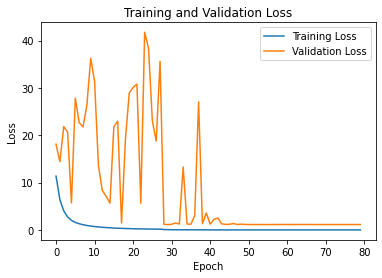

In [ ]:
# Get training and validation loss values from history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create plot
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')

# Set plot labels and legend
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Show plot
plt.show()


In [ ]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred, truth=True):
    if truth:
        input_len = np.ones(pred.shape[0]) * pred.shape[1]
        # Use greedy search. For complex tasks, you can use beam search.
        results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
            :, :max_len
        ]
        # Iterate over the results and get back the text.
    else: 
        results = pred
    
    output_text = []

    for res in results:
        if truth:
            res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        else:
            res = tf.gather(res, tf.where(tf.math.not_equal(res, padding_token)))

        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

<class 'tensorflow.python.framework.ops.EagerTensor'>
2/2 [==============================] - 2s 8ms/step


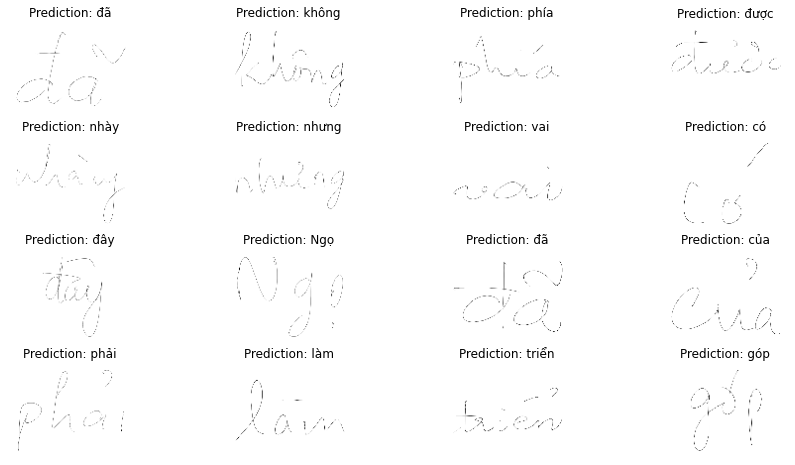

In [ ]:
for batch in test_ds.take(1):
    batch_images = batch["image"]
    print(type(batch_images))
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

In [ ]:
model.evaluate(test_ds)

393/393 [==============================] - 44s 112ms/step - loss: 1.2076


1.2076234817504883

In [ ]:
PATH_MODEL = r'/content/drive/MyDrive/nghien_cuu_khoa_hoc/draft/hugdo/save_model/280323(original)V3.hdf5'


In [ ]:
# prediction_model.save(PATH_MODEL)
# # Comment lại do đã lưu

In [ ]:
loaded_model = tf.keras.models.load_model(PATH_MODEL)

In [ ]:
loaded_model.predict(test_ds).shape

/usr/local/lib/python3.9/dist-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['label'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


393/393 [==============================] - 13s 29ms/step


(25115, 16, 198)

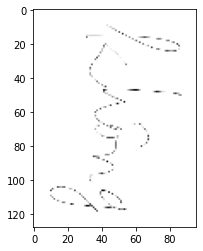

In [ ]:
x_test = list(test_ds.take(4))[0]['image'][1]
plt.imshow(x_test, cmap="gray")


1/1 [==============================] - 2s 2s/step
[[[2.6096818e-15 5.1695342e-10 2.0513284e-13 ... 3.1475273e-16
   5.5234923e-16 3.5444762e-07]
  [5.1756048e-16 2.9391387e-12 4.2980172e-16 ... 5.5253964e-17
   4.5825320e-17 9.9997866e-01]
  [5.5747622e-15 2.7608172e-12 5.1527060e-15 ... 5.4313026e-17
   8.4342081e-17 9.9999940e-01]
  ...
  [5.7302059e-28 8.4500044e-22 2.3331865e-26 ... 2.0290647e-26
   3.2852405e-26 1.0000000e+00]
  [3.7580869e-22 1.0099324e-16 7.7585131e-21 ... 5.2812481e-21
   1.5344885e-20 1.0000000e+00]
  [2.8427010e-15 5.6377698e-12 1.4941003e-15 ... 1.6873183e-15
   1.9479085e-15 2.8377757e-08]]]
['có']
<class 'tensorflow.python.framework.ops.EagerTensor'>


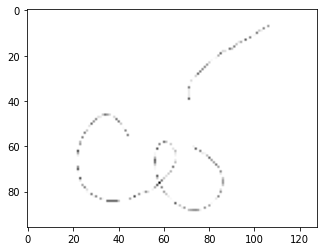

In [ ]:

x_test = list(test_ds.take(4))[1]['image'][63]

x_test = tf.reshape(x_test, [1, 128, 96, 1])

y_pred = loaded_model.predict(x_test)
print(y_pred)

x_test = tf.reshape(x_test, [128, 96, 1])
x_test = tf.image.flip_left_right(x_test)
x_test = tf.transpose(x_test, perm=[1, 0, 2])
plt.imshow(x_test, cmap="gray")

text_pred = decode_batch_predictions(y_pred)
print(text_pred)


print(type(x_test))

In [ ]:
def lev(s, r):
    if len(s) == 0:
        return len(r)

    if len(r) == 0:
        return len(s)

    if s[0] == r[0]:
        return lev(s[1:], r[1:])
    
    return 1 + min(lev(s[1:], r), lev(s, r[1:]), lev(s[1:], r[1:]))

def CER(truth, pred):
    return (100 / len(truth)) * lev(truth, pred)


def CER_of(data):
    batch_pred = []
    batch_truth = []
    num_batches = tf.data.experimental.cardinality(data).numpy()
    for mini_batch in data.take(num_batches):
        batch_images = mini_batch["image"]
        batch_texts = mini_batch['label']

        preds = loaded_model.predict(batch_images)
        pred_texts = decode_batch_predictions(preds)
        truth_texts = decode_batch_predictions(batch_texts, truth=False)

        batch_pred += pred_texts
        batch_truth += truth_texts

    batch_pred = np.array(batch_pred)
    batch_truth = np.array(batch_truth)

    len_data = len(batch_pred)

    valid_distances = 0
    for i in range(len_data):
        valid_distances += CER(batch_truth[i], batch_pred[i])

    average_distance = valid_distances / len_data

    return average_distance

    

In [ ]:
CER_train = CER_of(train_ds)
CER_val = CER_of(validation_ds)
CER_test = CER_of(test_ds)

1/1 [==============================] - 0s 36ms/step


In [ ]:
CER_train, CER_val, CER_test

(0.017788459146253474, 6.554623101028619, 6.665601724132492)

_____